In [1]:
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, Union

import pandas as pd
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from loguru import logger
from mads_datasets import DatasetFactoryProvider, DatasetType
from matplotlib import pyplot as plt
import mlflow
from mltrainer import ReportTypes, Trainer, TrainerSettings, metrics
from mltrainer.preprocessors import BasePreprocessor
from pydantic import BaseModel
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

/Users/koendirkvanesterik/Projects/mads/mads-ml-koenvanesterik/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
flowers_dataset_factory = DatasetFactoryProvider.create_factory(
    DatasetType.FLOWERS
)

In [3]:
data_streamer = flowers_dataset_factory.create_datastreamer(
    batchsize=64,
    preprocessor=BasePreprocessor(),
)
train_streamer = data_streamer["train"].stream()
valid_streamer = data_streamer["valid"].stream()

2026-01-16 12:02:46.001 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/koendirkvanesterik/.cache/mads_datasets/flowers


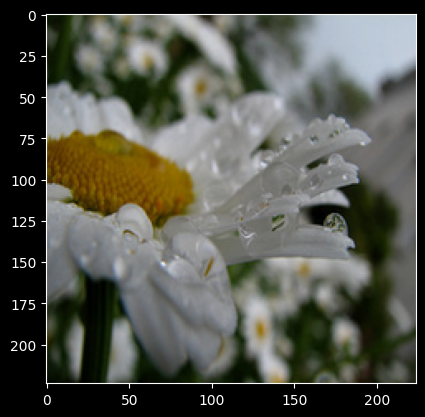

In [4]:
image, label = next(train_streamer)

index = 2
first_image = image[index]
first_image = first_image.permute(1, 2, 0)

plt.imshow(first_image)
plt.show()

In [5]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("mlflow-flowers-hyperopt")

2026/01/16 12:02:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/16 12:02:56 INFO mlflow.store.db.utils: Updating database tables
2026-01-16 12:02:56 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2026-01-16 12:02:56 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2026-01-16 12:02:56 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2026-01-16 12:02:56 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/Users/koendirkvanesterik/Projects/mads/mads-ml-koenvanesterik/notebooks/hypertuning/mlruns/1', creation_time=1768406934538, experiment_id='1', last_update_time=1768406934538, lifecycle_stage='active', name='mlflow-flowers-hyperopt', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [6]:
class ModelConfig(BaseModel):
    features: int
    num_classes: int
    kernel_size: int
    filter1: int
    filter2: int
    dropout: float = 0
    has_batchnorm: bool = True


class FlowersModel(nn.Module):
    def __init__(
        self,
        config: ModelConfig,
    ) -> None:
        super().__init__()

        self._convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=config.features,
                out_channels=config.filter1,
                kernel_size=config.kernel_size,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(config.filter1) if config.has_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=config.filter1,
                out_channels=config.filter2,
                kernel_size=config.kernel_size,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(config.filter2) if config.has_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=config.filter2,
                out_channels=32,
                kernel_size=config.kernel_size,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(32) if config.has_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self._dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, config.num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._convolutions(x)
        return self._dense(x)

In [11]:
settings = TrainerSettings(
    epochs=50,
    metrics=[metrics.Accuracy()],
    logdir="modellogs",
    train_steps=180,
    valid_steps=180,
    reporttypes=[ReportTypes.MLFLOW, ReportTypes.TOML],
    optimizer_kwargs={"lr": 0.1},
)

In [12]:
def objective(params: Dict[str, Union[int, float]]) -> Dict[str, Any]:
    with mlflow.start_run():
        mlflow.set_tag("model", "cnn")
        mlflow.set_tag("dev", "vanesterik")
        mlflow.log_params(params)

        model = FlowersModel(ModelConfig(**params))
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=nn.CrossEntropyLoss(),
            optimizer=optim.Adam,
            traindataloader=train_streamer,
            validdataloader=valid_streamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            device=torch.device("mps"),
        )
        trainer.loop()

        tag = datetime.now().strftime("%Y%m%d-%H%M")
        models_dir = Path("models").resolve()

        if not models_dir.exists():
            models_dir.mkdir()
            logger.info(f"Created {models_dir}")

        models_path = models_dir / (tag + "model.pt")
        torch.save(model, models_path)

        mlflow.log_artifact(
            local_path=models_path, artifact_path="pytorch_models"
        )

        return {"loss": trainer.test_loss, "status": STATUS_OK}


In [13]:
search_space = {
    "dropout": 0.25428392690546453,
    "features": 3,
    "filter1": 64,
    "filter2": 32,
    "kernel_size": 3,
    "num_classes": 5,
    "has_batchnorm": True,
}

In [15]:
results = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1,
    trials=Trials(),
)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2026-01-16 12:07:38.047 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20260116-120738
2026-01-16 12:07:38.058 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 180/180 [01:34<00:00,  1.90it/s]
2026-01-16 12:09:37.310 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.4357 test 1.2871 metric ['0.4396']
100%|##########| 180/180 [01:33<00:00,  1.92it/s]
2026-01-16 12:11:35.485 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 1.3074 test 1.3160 metric ['0.4011']
2026-01-16 12:11:35.486 | INFO     | mltrainer.trainer:__call__:252 - best loss: 1.2871, current loss 1.3160.Counter 1/10.
100%|##########| 180/180 [01:33<00:00,  1.92it/s]
2026-01-16 12:13:33.798 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 1.2810 test 1.1586 metric ['0.5146']
100%|##########| 180/180 [01:35<00:00,  1.88it/s]
2026-01-16 12:15:34.193 | INFO     | mltrainer.trainer:re

100%|██████████| 1/1 [1:22:08<00:00, 4928.45s/trial, best loss: 0.8957249141401715]


In [ ]:
logger.info(f"\n\n{results}")

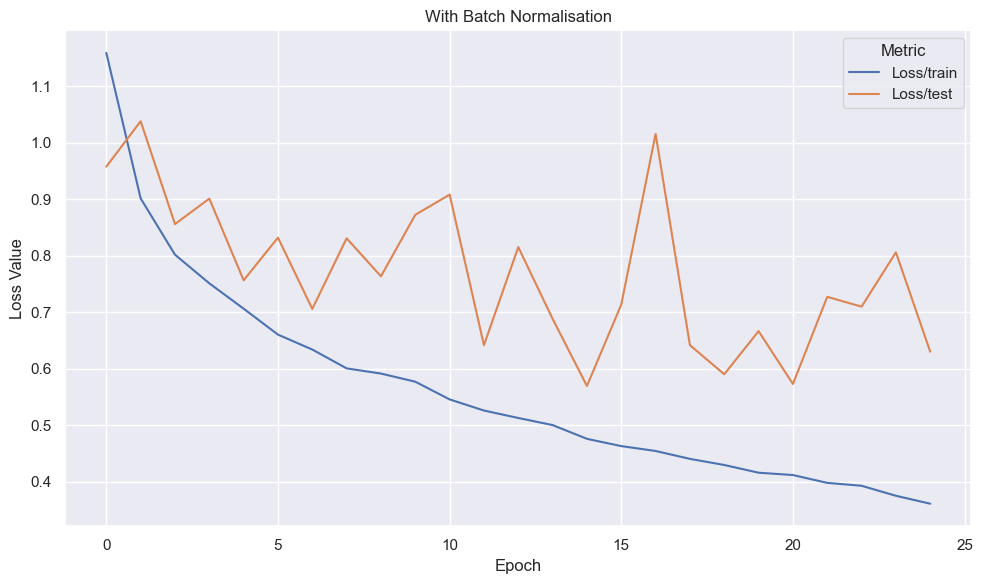

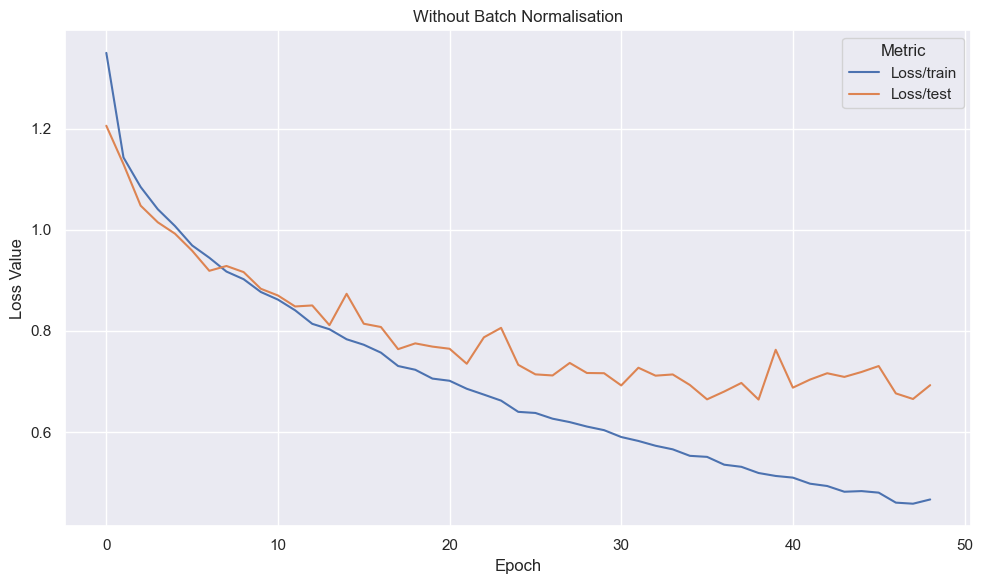

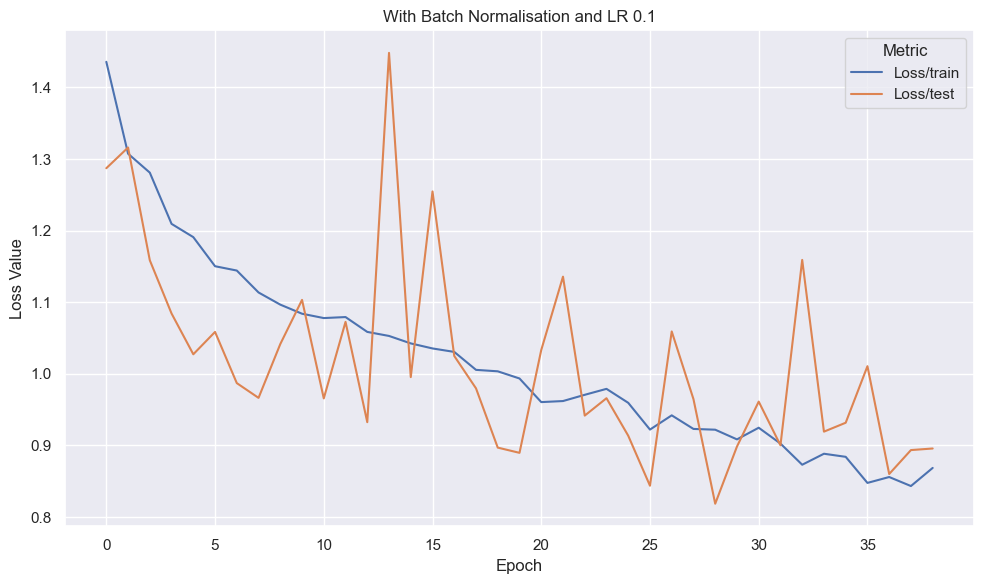

In [16]:
datasets = ["with_batchnorm.csv", "without_batchnorm.csv", "with_batchnorm_lr_0_1.csv"]

sns.set_theme(style="darkgrid")

for dataset in datasets:
    df = pd.read_csv(dataset)

    # Filter for train and test loss metrics
    df_filtered = df[df["metric"].isin(["Loss/train", "Loss/test"])]

    # Create lineplot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_filtered, x="step", y="value", hue="metric")
    plt.title(
        "With Batch Normalisation"
        if dataset == "with_batchnorm.csv"
        else "Without Batch Normalisation"
        if dataset == "without_batchnorm.csv"
        else "With Batch Normalisation and LR 0.1"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.savefig(f"../../assets/images/{dataset.replace('.csv', '.png')}")
    plt.show()